In [ ]:
# PyTorch
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.utils import make_grid

# Data manipulations
import numpy as np
from PIL import Image
import cv2
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt

# helpers
import glob
import os
import copy
import time
import csv

# data loader
from data_loader import ApplyClaheColor
from data_loader import Denoise
from data_loader import Resize
from data_loader import ToTensor
from data_loader import Normalize
from data_loader import SegmentationDataset

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


DAIUnet(
  (encoder1): ResidualStem(
    (conv_block1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_block2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_skip): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [ ]:
def get_data_loaders(data_dir, image_folder='training_data/img', mask_folder='training_data/label', batch_size=4):
    
    data_transforms = {
        'training': transforms.Compose([ApplyClaheColor(), Denoise(), Resize((320, 320), (320, 320)), ToTensor(), Normalize()]),
        'test': transforms.Compose([ApplyClaheColor(), Denoise(), Resize((320, 320), (320, 320)),ToTensor(), Normalize()]),
    }
    
    image_datasets = {x: SegmentationDataset(root_dir=data_dir,
                                             transform=data_transforms[x],
                                             image_folder=image_folder,
                                             mask_folder=mask_folder,
                                             subset=x)
                      for x in ['training', 'test']}
    
    data_loaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0)
                    for x in ['training', 'test']}
    
    return data_loaders


def plot_batch_from_dataloader(dataloaders, batch_size):
    """

    :param dataloaders: dataset dataloaders
    :param batch_size: size of the batch to plot
    :return: void
    """
    batch = next(iter(dataloaders['training']))

    for i in range(batch_size):

        np_img = batch['image'][i].numpy()
        np_mask = batch['mask'][i].numpy()

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(np.transpose(np_img, (1, 2, 0)))
        ax[1].imshow(np.squeeze(np.transpose(np_mask, (1, 2, 0))), cmap='gray')
        plt.show()


def myimshow(img, unnormalize=False):
    """

    :param img: tensor of images, first dimension is number of images in the batch
    :param unnormalize: whenever to unnormalize the image before plotting
    :return: void
    """
    if unnormalize:
        img = img * 255

    np_img = img.numpy()
    plt.imshow(np.transpose(np_img[0], (1, 2, 0)))
    plt.show()


def images_generator(path):
    for img_name in glob.glob(os.path.join(path, '*')):
        image = np.array(Image.open(img_name)).transpose(2, 0, 1)
        yield image

After preparing the data, one need to implement class representing the dataset and corresponding dataloaders. It is a convention of PyTorch, deep learning framework that I'm using.

I decided to use this idea for my dataset, because it might work quite well, and also I would learn a lot.

I have prepared several transformations to be applied on the images. I've used random flip as augmentation technique. I am also using CLAHE (Contrast Limiting Adaptive Histogram Equalization) nad Bilateral filter to improve the quality of images: CLAHE preforms histogram equalization in a smart way. I included Bilateral filter because I've noticed that after CLAHE the pictures are a little bit noisy. I decided to use bilateral filter instead of median filter because it keeps the edges sharp, what is crucial in segmentation task.

In [ ]:
def accuracy(y_true, y_pred):
    
    mask = np.zeros_like(y_pred)
    mask[y_pred >= 0.5] = 1

    compare = np.equal(mask, y_true)
    accuracy = np.sum(compare)

    return accuracy/len(y_pred.flatten())

def IoU(y_true, y_pred):
    # jaccard_score
    SMOOTH = 1e-6
    
    mask = np.zeros_like(y_pred)
    mask[y_pred >= 0.5] = 1
    
    intersection = np.logical_and(mask, y_true)
    union = np.logical_or(mask, y_true)
    
    iou_score = (np.sum(intersection) + SMOOTH) / (np.sum(union) + SMOOTH)
    return iou_score


def precision_and_recall(label_gt, label_pred, n_class):
    from sklearn.metrics import precision_score, recall_score
    assert len(label_gt) == len(label_pred)
    precision = np.zeros(n_class, dtype=np.float32)
    recall = np.zeros(n_class, dtype=np.float32)
    mask = np.zeros_like(label_pred)
    mask[label_pred >= 0.5] = 1
    
    img_A = np.array(label_gt, dtype=np.int64).flatten()
    img_B = np.array(mask, dtype=np.int64).flatten()
    precision[:] = precision_score(img_A, img_B, average=None, labels=range(n_class))
    recall[:] = recall_score(img_A, img_B, average=None, labels=range(n_class))

    return precision, recall
    
def dice_coeff(prediction, target):

    mask = np.zeros_like(prediction)
    mask[prediction >= 0.5] = 1

    inter = np.sum(mask * target)
    union = np.sum(mask) + np.sum(target)
    epsilon=1e-6
    result = np.mean(2 * inter / (union + epsilon))
    return result


class FocalLoss(nn.modules.loss._WeightedLoss):

    def __init__(self, gamma=0, size_average=None, ignore_index=-100,
                 reduce=None, balance_param=1.0):
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input, target):
        
        # inputs and targets are assumed to be BatchxClasses
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)
           
        # compute the negative likelyhood
        logpt = - F.binary_cross_entropy_with_logits(input, target)
        pt = torch.exp(logpt)

        # compute the loss
        focal_loss = -( (1-pt)**self.gamma ) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss


There is quite some code needed to got everything working. In the training loop I'am tracking loss in each batch for each epoch, and save it for plotting the learning curve.

Let's take a look at the images and their correspodning masks

In [ ]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        # number of input channels is a number of filters in the previous layer
        # number of output channels is a number of filters in the current layer
        # "same" convolutions
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UpConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out


class AttentionUNet(nn.Module):

    def __init__(self, img_ch=3, output_ch=1):
        super(AttentionUNet, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = ConvBlock(img_ch, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv4 = ConvBlock(256, 512)
        self.Conv5 = ConvBlock(512, 1024)

        self.Up5 = UpConv(1024, 512)
        self.Att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)
        self.UpConv5 = ConvBlock(1024, 512)

        self.Up4 = UpConv(512, 256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)

        self.Up3 = UpConv(256, 128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)

        self.Up2 = UpConv(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)

        self.Conv = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """
        e : encoder layers
        d : decoder layers
        s : skip-connections from encoder layers to decoder layers
        """
        e1 = self.Conv1(x)

        e2 = self.MaxPool(e1)
        e2 = self.Conv2(e2)

        e3 = self.MaxPool(e2)
        e3 = self.Conv3(e3)

        e4 = self.MaxPool(e3)
        e4 = self.Conv4(e4)

        e5 = self.MaxPool(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        s4 = self.Att5(gate=d5, skip_connection=e4)
        d5 = torch.cat((s4, d5), dim=1) # concatenate attention-weighted skip connection with previous layer output
        d5 = self.UpConv5(d5)

        d4 = self.Up4(d5)
        s3 = self.Att4(gate=d4, skip_connection=e3)
        d4 = torch.cat((s3, d4), dim=1)
        d4 = self.UpConv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(gate=d3, skip_connection=e2)
        d3 = torch.cat((s2, d3), dim=1)
        d3 = self.UpConv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(gate=d2, skip_connection=e1)
        d2 = torch.cat((s1, d2), dim=1)
        d2 = self.UpConv2(d2)

        out = self.Conv(d2)

        return out


Model Training

In [ ]:
from data_loader import TestDataset

def test_data_loader(root_dir, image_folder='test_data/img', mask_folder='test_data/label', batch_size=4):
    
    data_transforms = transforms.Compose([ApplyClaheColor(), Denoise(), Resize((320, 320), (320, 320)), ToTensor(), Normalize()])
    
    image_datasets = TestDataset(root_dir = root_dir, image_folder = image_folder, mask_folder = mask_folder, transform = data_transforms)
    
    data_loaders = DataLoader(image_datasets, batch_size=batch_size, shuffle=True, num_workers=0)
    
    return data_loaders


We can see that the model converges nicely. I plotted the loss starting from 20th epoch, because at the very beginning of the training it jumped that much, so one could not see what was happening next - the plot was almost flat

In [ ]:
saved_model_name = 'saved_modelsAttUnet_best_loss_0.014017'

model_dir = os.path.join(os.getcwd(), saved_model_name + '.pth')

indexs= ['dice_score', 'acc_score', 'iou_score', 'precision', 'recall']
dice_scores, acc_scores, iou_scores, precisions, recalls = 0, 0, 0, 0, 0

test_summary = {a: 0 for a in indexs}

# --------- 2. dataloader ---------
#1. dataloader
data_dir = os.getcwd()
test_data_loaders = test_data_loader(data_dir)

# --------- 3. model define ---------
model = AttentionUNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

if torch.cuda.is_available():
    model.load_state_dict(torch.load(model_dir))
    model.cuda()
else:
    model.load_state_dict(torch.load(model_dir, map_location='cpu'))
model.eval()

# --------- 4. inference for each image ---------
for sample in iter(test_data_loaders):

    inputs = sample['image'].to(device)
    masks = sample['mask'].to(device)

    # track history only in training phase

    outputs = model(inputs)

    y_pred = outputs.data.cpu().numpy().ravel()
    y_true = masks.data.cpu().numpy().ravel()

    dice_scores += dice_coeff(y_pred, y_true)
    
    acc_scores += accuracy(y_true, y_pred)
    
    iou_scores += IoU(y_true, y_pred)
    
    precision, recall = precision_and_recall(y_true, y_pred, n_class = 2)
    precisions += precision
    recalls += recall


test_summary['dice_score'] = dice_scores / len(test_data_loaders)
test_summary['acc_score'] = acc_scores / len(test_data_loaders)
test_summary['iou_score'] = iou_scores / len(test_data_loaders)
test_summary['precision'] = precisions / len(test_data_loaders)
test_summary['recall'] = recalls / len(test_data_loaders)
print(test_summary)

{'dice_score': 0.6057589040954898, 'acc_score': 0.9086910978618422, 'iou_score': 0.40516493447518753, 'precision': array([0.97799706, 0.5258019 ], dtype=float32), 'recall': array([0.9731989 , 0.59221935], dtype=float32)}


In [ ]:

saved_model_name = 'saved_modelsDAIU_best_loss_0.001096'

model_dir = os.path.join(os.getcwd(), saved_model_name + '.pth')

indexs= ['dice_score', 'acc_score', 'iou_score', 'precision', 'recall']
dice_scores, acc_scores, iou_scores, precisions, recalls = 0, 0, 0, 0, 0

test_summary = {a: 0 for a in indexs}

# --------- 2. dataloader ---------
#1. dataloader
data_dir = os.getcwd()
test_data_loaders = test_data_loader(data_dir)

# --------- 3. model define ---------
if torch.cuda.is_available():
    model.load_state_dict(torch.load(model_dir))
    model.cuda()
else:
    model.load_state_dict(torch.load(model_dir, map_location='cpu'))
model.eval()

# --------- 4. inference for each image ---------
for sample in iter(test_data_loaders):

    inputs = sample['image'].to(device)
    masks = sample['mask'].to(device)

    # track history only in training phase

    outputs = model(inputs)

    y_pred = outputs.data.cpu().numpy().ravel()
    y_true = masks.data.cpu().numpy().ravel()

    dice_scores += dice_coeff(y_pred, y_true)
    
    acc_scores += accuracy(y_true, y_pred)
    
    iou_scores += IoU(y_true, y_pred)
    
    precision, recall = precision_and_recall(y_true, y_pred, n_class = 2)
    precisions += precision
    recalls += recall


test_summary['dice_score'] = dice_scores / len(test_data_loaders)
test_summary['acc_score'] = acc_scores / len(test_data_loaders)
test_summary['iou_score'] = iou_scores / len(test_data_loaders)
test_summary['precision'] = precisions / len(test_data_loaders)
test_summary['recall'] = recalls / len(test_data_loaders)
print(test_summary)

We can plot the predictions to make sure the model learned what we expect

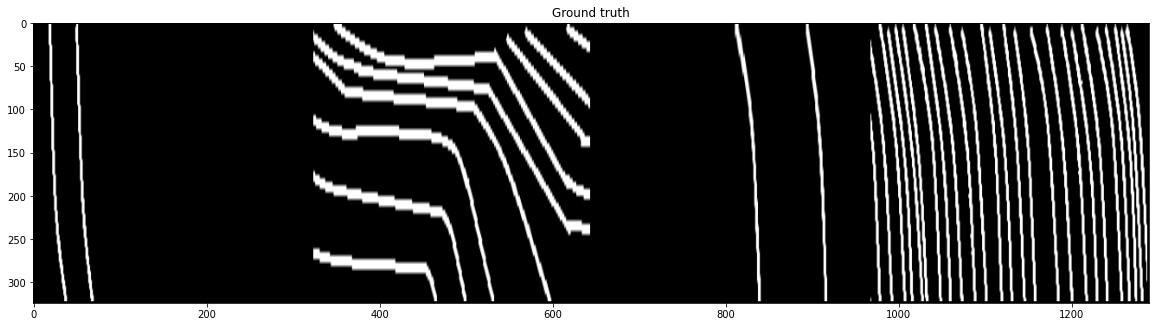

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


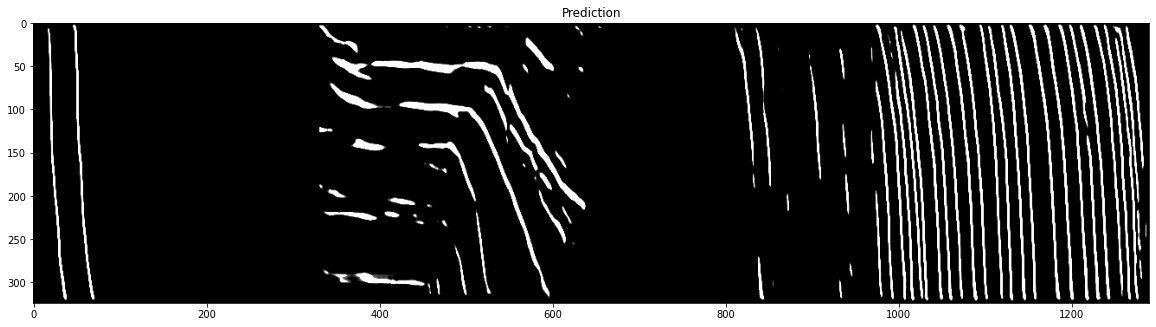

In [ ]:
dataiter = iter(test_data_loaders)
batch = dataiter.next()

f = plt.figure(figsize=(20, 20))
grid_img = make_grid(batch['mask'])
grid_img = grid_img.permute(1, 2, 0)
plt.imshow(grid_img)
plt.title('Ground truth')
plt.show()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = batch['image'].to(device)
prediction = model(inputs).detach().cpu()

prediction[prediction >= 0.5] = 1

f = plt.figure(figsize=(20, 20))
grid_img = make_grid(prediction)
grid_img = grid_img.permute(1, 2, 0)
plt.imshow(grid_img)
plt.title('Prediction')
plt.show()